In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
import math
import datetime
import statsmodels.api as sm
import statsmodels.stats.outliers_influence
from statsmodels.formula.api import glm

from datapackage import Package

# Settings
## Countries to Plot

In [2]:
countries_asia = ["China", "Singapore", "Korea, South"]
countries_europe = ["Italy", "Spain", "Germany","France", "Slovakia", "Switzerland", "United Kingdom"]
countries_latin_america = []

# Preperation
## Loading Data from JHU CSSE
Based upon the COVID-19 time series from Johns Hopkins CSSE
Source: GitHub repository https://github.com/CSSEGISandData/COVID-19
Population data source: https://datahub.io/core/population

In [3]:
df = pd.read_csv('data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

## Population Counts

In [4]:
package = Package('https://datahub.io/core/population/datapackage.json')

populations = package.get_resource("population_csv").read(keyed=True)

In [5]:
def get_population(country):
    additional = {"China Hubei": 58.5 * 10**6,
                  "Korea, South": 51245707.0,
                  "Slovakia": 5428704}
    if country in additional:
        return additional[country]
    
    population_ts = list(filter(lambda pop: pop['Country Name'] == country, populations))
    if population_ts is None or len(population_ts) == 0:
        return None
    latest_year = max(population_ts, key=lambda x:x['Year'])
    return float(latest_year['Value'])
    

## Loading Data from DXY

Source repository: https://github.com/BlankerL/DXY-COVID-19-Data

In [6]:
df_dxy = pd.read_csv('data/DXY-COVID-19-Data/csv/DXYArea.csv', parse_dates=["updateTime"])
def dtm_dxy(x):
    try:
        return datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S.%f")
    except:        
        return datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S")
df_dxy["updateTime"] = df_dxy["updateTime"].apply(dtm_dxy)
df_dxy = df_dxy.set_index('updateTime')

## Data Transformation

In [7]:
df_provinces = df.transpose()[:]
df_tr = df.transpose()[:]

In [8]:
provinces_header = df_provinces.iloc[1].fillna("-") + " " + df_provinces.iloc[0].fillna("")
provinces_header = provinces_header.str.strip()
df_provinces = df_provinces[4:] 
df_provinces.columns = provinces_header

In [9]:
new_header = df_tr.iloc[1] 
df_tr = df_tr[1:] 
df_tr.columns = new_header

In [10]:
df_total = df_tr.groupby(df_tr.columns, axis=1).sum()
df_total = df_total[3:]

In [11]:
df_total.index = pd.to_datetime(df_total.index)

In [12]:
df_all = pd.concat([df_total[["China", "Italy", "Austria"]], df_provinces["China Hubei"]], axis=1)
df_all_pops = np.array([get_population("China"), get_population("Italy"), get_population("Austria"), 58*10**6])
df_rel_confirmed = df_all/df_all_pops*100000
df_diffs = df_all.diff(1)
df_rel = df_diffs/df_all_pops*100000

In [13]:
x = np.linspace(1, len(df_all), num=len(df_all))
latest_date = datetime.datetime.strftime(df_rel_confirmed["Austria"].index[-1], "%Y-%m-%d")

# Time Series Development

## Doubling Time Estimation

In [14]:
def estimate_T2(df, country, t_half=5):
    y = df[country].fillna(0).values
    x = np.linspace(1, len(y), num=len(y))
    weights = np.flip(np.exp(-np.log(2)/t_half * x))

    model = lmfit.models.ExponentialModel()
    pars = model.guess(y, x=x)
    fit_lm = model.fit(y, pars, x=x, weights=weights)
    T2 = np.log(2)/(-1/fit_lm.best_values["decay"])
    T2Err = np.abs(-np.log(2) * fit_lm.params["decay"].stderr)
    
    return (fit_lm, T2, T2Err)

In [15]:
def days_rel_to_absolute(df, x):
    return [df.index[0] + datetime.timedelta(days=day-1) for day in x]

## Poisson Regression, Doubling Time Plot

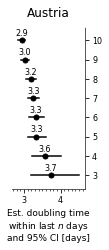

In [16]:
def estimate_t2_poisson_regression(data, last_days = 5, alpha=0.05):
    offset= len(data) - last_days
    data_trunc = data[-last_days:]
    y = data_trunc.values.astype("float64")
    x = np.linspace(offset+1, last_days+offset, num=abs(last_days))

    model = glm('y ~ x',
        data = data_trunc,
        family = sm.families.Poisson()
    ).fit()
    
    t2_est = np.log(2)/model.params['x']
    
    ci = model.conf_int(alpha)
    t2_ci_lower = np.log(2)/ci[1]["x"]
    t2_ci_upper = np.log(2)/ci[0]["x"]
    
    return (t2_est, t2_ci_lower, t2_ci_upper, model)

fig, ax = plt.subplots(figsize=(1.5,3.35))

for i in range(3, 11):
    est = estimate_t2_poisson_regression(df_total["Austria"][:], i)
    plt.plot(est[0], i, "ko", markersize=5)
    plt.plot([est[1], est[2]], np.ones(2)*i, "k")
    ax.annotate("%.1f" % est[0], xy=(est[0], i+0.23), horizontalalignment="center", fontsize=8)
#ax.set_ylabel("Poisson regression over last $n$ days", fontsize=9)
ax.set_xlabel("Est. doubling time\nwithin last $n$ days\nand 95% CI [days]", fontsize=9)
ax.set_title("Austria", fontsize=12, pad=10)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.1))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
ax.tick_params(labelsize=8)
plt.margins(0.1, 0.1)

ax.spines['bottom'].set_color('#333333')
ax.spines['top'].set_color('#ffffff') 
ax.spines['right'].set_color('#333333')
ax.spines['left'].set_color('#ffffff')

fig.subplots_adjust(bottom=0.21, right=0.8)
fig.savefig('inset-poisson-regression-%s.png' % latest_date, dpi=160)

# Combined Data Plot, logarithmic

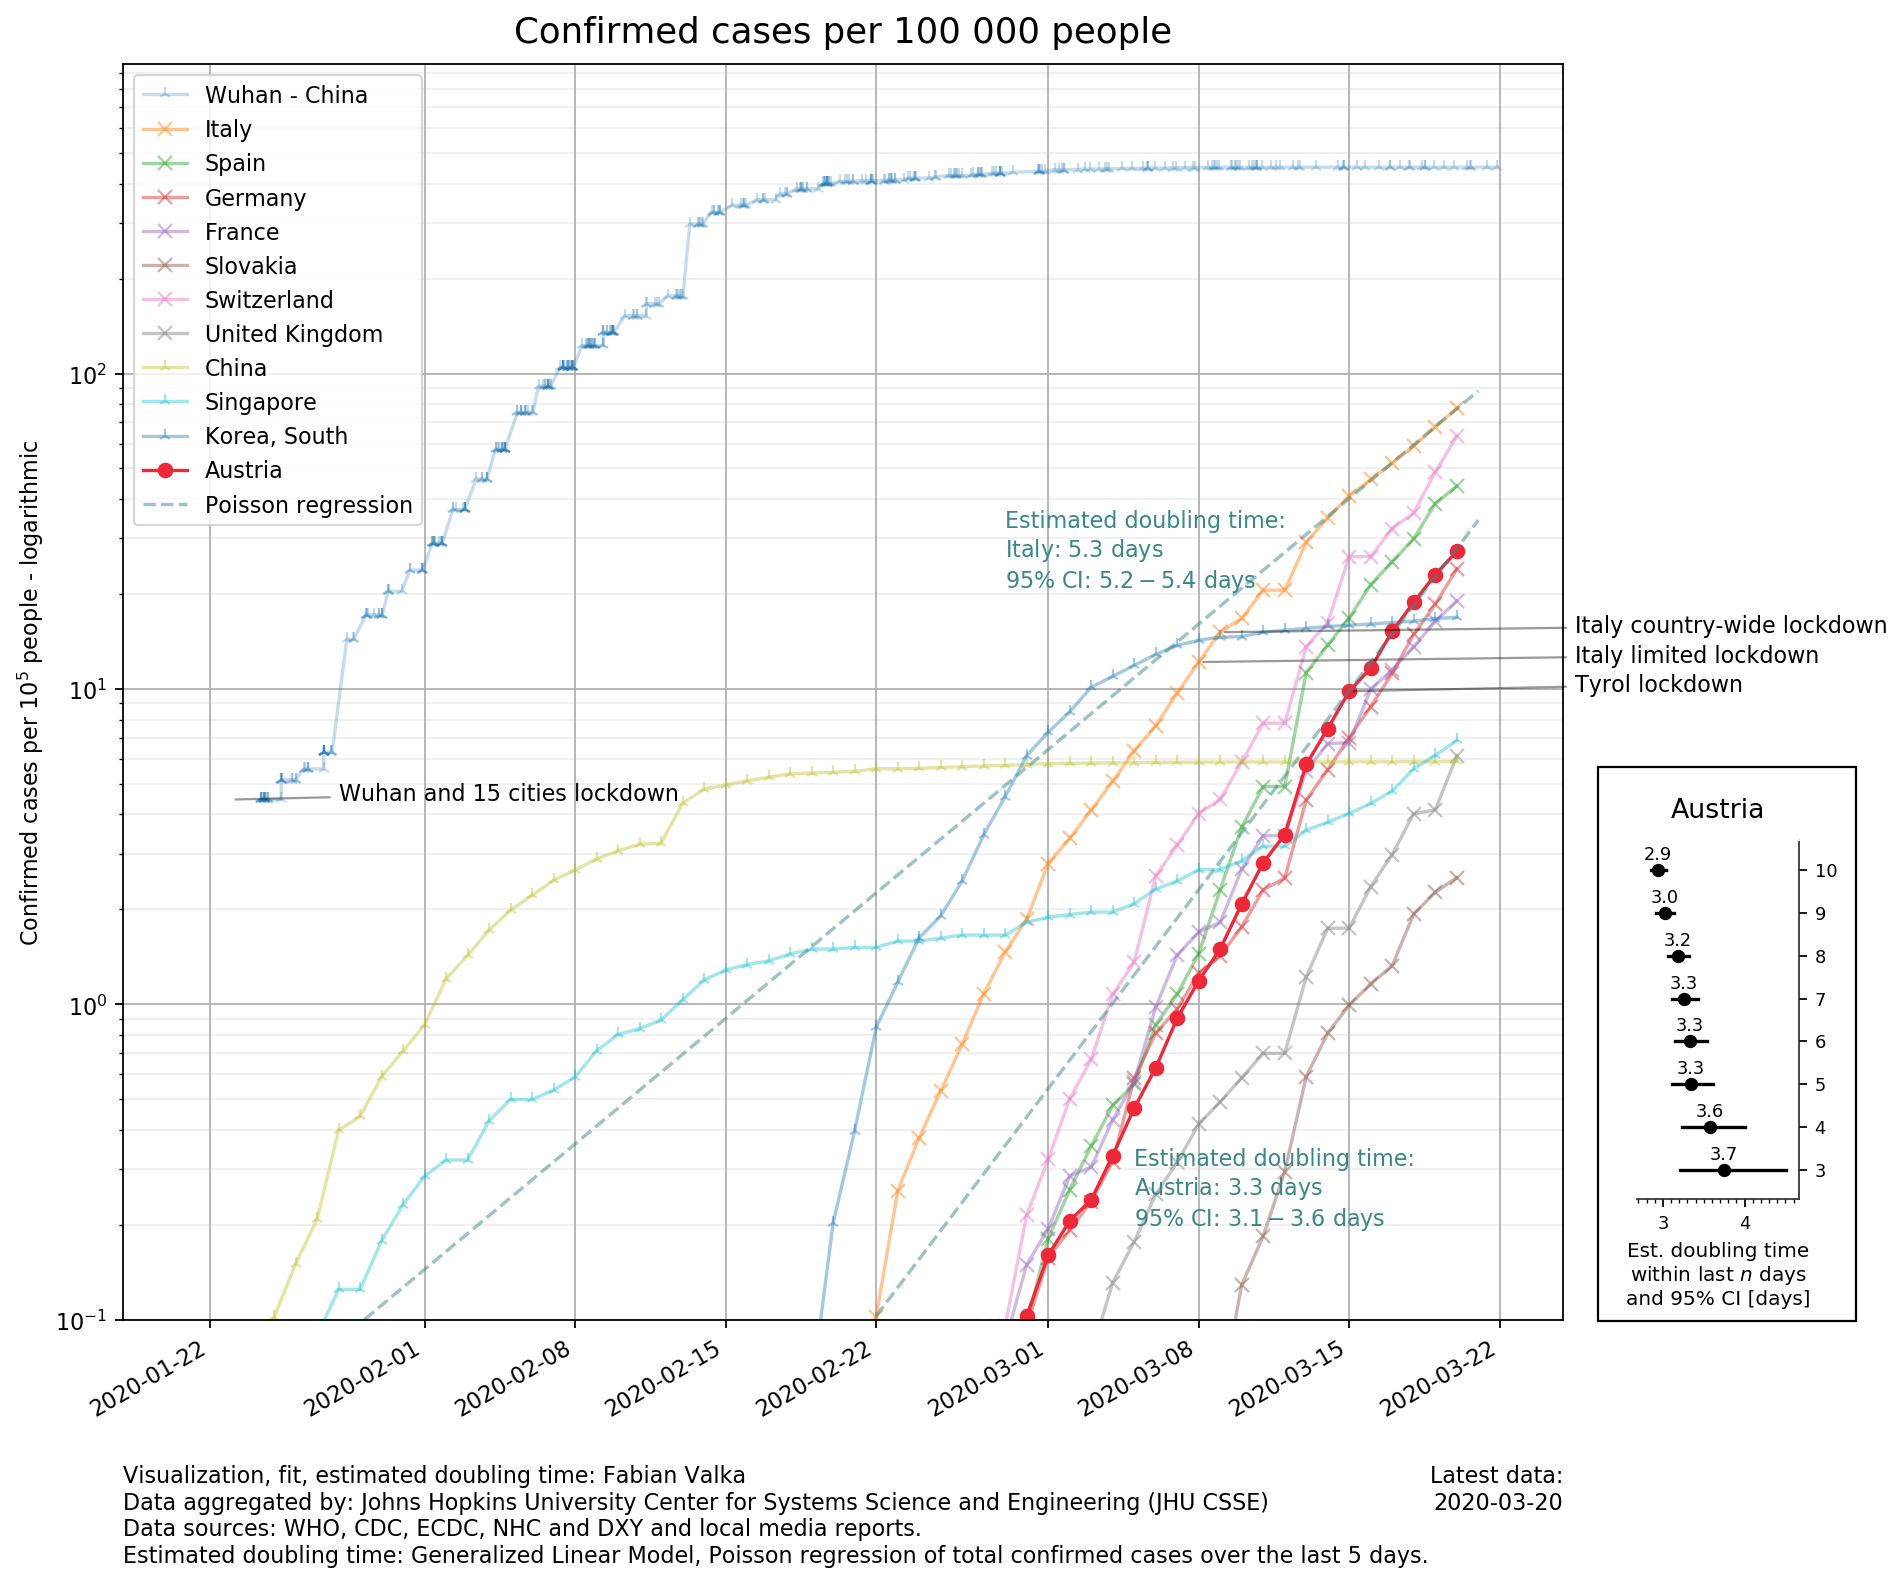

In [17]:
fig, ax = plt.subplots(figsize=(12,10), dpi=160)

def get_per_capita(df, countries):
    pops = [get_population(country) for country in countries]
    return df_total[countries]/pops*10**5

(df_dxy[df_dxy["cityEnglishName"]=="Wuhan"]["city_confirmedCount"]/(11.08*10**6)*10**5).plot(ax=ax, style="-", alpha=0.25, marker="2")

# Plotting
get_per_capita(df_total, countries_europe).plot(ax=ax, style="-", alpha=0.45, marker="x")
get_per_capita(df_total, countries_asia).plot(ax=ax, style="-", alpha=0.4, marker="2")
plt.plot(get_per_capita(df_total, ["Austria"]), "o-", color="#ED2939")

# Fit
# Austria
x_fit = np.linspace(0, len(df_total)+1, num=len(df_total)*10)
t2_est, t2_ci_lower, t2_ci_upper, t2_model = estimate_t2_poisson_regression(df_total["Austria"])

ax.plot(days_rel_to_absolute(df_total, x_fit), 
        t2_model.predict(pd.DataFrame({'x':x_fit}))/get_population("Austria")*10**5, 
        "--", alpha=0.5, color='#3B8686')

T2_text = "Estimated doubling time:\nAustria: $%.1f$ days\n95%% CI: $%.1f-%.1f$ days" % (t2_est, t2_ci_lower, t2_ci_upper)
ax.annotate(T2_text, xy=(pd.to_datetime("2020-03-05"), 0.2), color='#3B8686')

# Italy
x_fit = np.linspace(0, len(df_total)+1, num=len(df_total)*10)
t2_est, t2_ci_lower, t2_ci_upper, t2_model = estimate_t2_poisson_regression(df_total["Italy"])

ax.plot(days_rel_to_absolute(df_total, x_fit), 
        t2_model.predict(pd.DataFrame({'x':x_fit}))/get_population("Italy")*10**5, 
        "--", alpha=0.5, color='#3B8686')

T2_text = "Estimated doubling time:\nItaly: $%.1f$ days\n95%% CI: $%.1f-%.1f$ days" % (t2_est, t2_ci_lower, t2_ci_upper)
ax.annotate(T2_text, xy=(pd.to_datetime("2020-02-28"), 21), color='#3B8686')

# Plot decoration
plt.legend(["Wuhan - China"] + countries_europe + countries_asia + ["Austria" ,"Poisson regression"])
ax.grid(True)
ax.grid(True, 'minor', alpha=0.2)
ax.set_title(r'Confirmed cases per 100 000 people', fontsize=16, pad=10)
ax.set_xlabel(None)
ax.set_ylabel("Confirmed cases per $10^5$ people - logarithmic")
ax.set_yscale('log')
ax.tick_params(axis='y', which='minor', bottom=False)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(np.linspace(0,1,num=11)),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# Annotations
def annotate_country_event(df, country, day, text):
    val = df[country][day]/get_population(country)*10**5
    x_pos = pd.to_datetime(day)
    x_text = df[country].index[-1] + pd.Timedelta(5.5, "D")
    ax.annotate(text, xy=(x_pos, val),
                xytext=(x_text, val),
                arrowprops=dict(facecolor='black', arrowstyle='-', alpha=0.4),
                )

annotate_country_event(df_total, "Italy", "2020-03-09", "Italy country-wide lockdown")
annotate_country_event(df_total, "Italy", "2020-03-08", "Italy limited lockdown")
annotate_country_event(df_total, "Austria", "2020-03-15", "Tyrol lockdown")
ax.annotate("Wuhan and 15 cities lockdown", xy=(pd.to_datetime("2020-01-23"), 495/111),
            xytext=(pd.to_datetime("2020-01-28"), 495/111),
            arrowprops=dict(facecolor='black', arrowstyle='-', alpha=0.4)
            )
ax.set_ylim(0.1,)

# Source and notes
ax.annotate('Visualization, fit, estimated doubling time: Fabian Valka\n' + 
            'Data aggregated by: Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE)\n'+
            'Data sources: WHO, CDC, ECDC, NHC and DXY and local media reports.\n' +
           r'Estimated doubling time: Generalized Linear Model, Poisson regression of total confirmed cases over the last 5 days.', 
            (0,0), (0, -65), xycoords='axes fraction', textcoords='offset points', va='top')

ax.annotate('Latest data:\n%s' % latest_date, 
            (1,0), (0, -65), xycoords='axes fraction', textcoords='offset points', va='top', horizontalalignment="right")


# Add inset 
arr_img = plt.imread('inset-poisson-regression-%s.png' % latest_date, format='png')

imagebox = OffsetImage(arr_img, dpi_cor=False)
imagebox.image.axes = ax

ab = AnnotationBbox(imagebox, (1.112,0.219),
                    xycoords='axes fraction',
                    boxcoords="offset points"
                    )

ax.add_artist(ab)

plt.tight_layout()
fig.savefig('confirmed-cases-per-capita-%s.png' % latest_date, dpi=160)

### Quality of Fit for Poisson Regression

In [18]:
t2_est, t2_ci_lower, t2_ci_upper, t2_model = estimate_t2_poisson_regression(df_total["Austria"])
t2_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                    5
Model:                            GLM   Df Residuals:                        3
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -25.407
Date:                Mon, 23 Mar 2020   Deviance:                       4.7126
Time:                        06:33:38   Pearson chi2:                     4.69
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.4427      0.456     -9.753      0.000      -5.335      -3.550
x              0.2075      0.008     26.156      0.000       0.192       0.223
==============================================================================
"""

In [19]:
print(t2_model.params)
np.zeros_like(t2_model.params)

Intercept   -4.442660
x            0.207477
dtype: float64


array([0., 0.])

In [20]:
t2_model.get_influence().summary_frame()

,dfb_Intercept,dfb_x,cooks_d,standard_resid,hat_diag,dffits_internal
0,-1.781013,1.757456,2.048660,-1.967898,0.514097,-2.024184
1,0.406592,-0.397399,0.154414,0.812469,0.318730,0.555723
2,0.162020,-0.149933,0.139411,1.028949,0.208456,0.528035
3,-0.201274,0.213193,0.145210,0.865044,0.279594,0.538907
4,1.885941,-1.926361,3.240007,-1.749775,0.679124,-2.545587


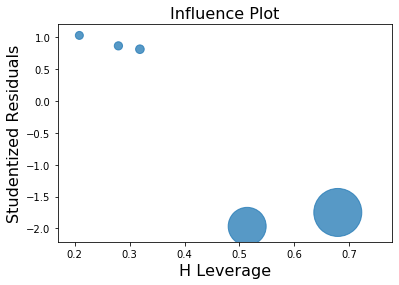

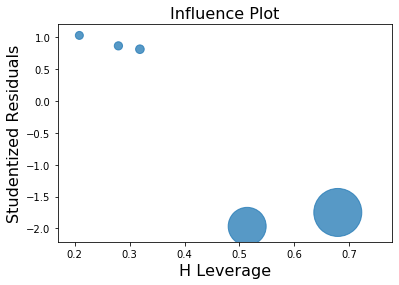

In [21]:
t2_model.get_influence().plot_influence()

In [22]:
t2_model.tvalues

Intercept    -9.753318
x            26.156058
dtype: float64

# Austria and Italy Total number of cases

## Austria

In [23]:
df_total["Austria"][-1]

2388

## Italy

In [24]:
df_total["Italy"][-1]

47021

# Italy Compared to China, latest cumulative cases per inhabitant

In [25]:
(df_total["Italy"][-1]/get_population("Italy"))/(df_total["China"][-1]/get_population("China"))

13.165895064718017